In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
import py_ddspls

In [6]:
from utils.brain import matrix_from_vector

## Subject demographics

In [7]:
demo_std_path = 'data/output/processed_demographics.csv'

In [8]:
demo_std = pd.read_csv(demo_std_path)
print('demographics',demo_std.shape)

demographics (50, 11)


In [9]:
demo_names = demo_std.columns[1:]

## Subject brain vectors

In [10]:
stackedVecs = np.load('data/output/subject_brain_vectors.npy')
stackedVecs.shape

(50, 54946)

## Partial Leas Squares (Sparse)

In [11]:
X, Y = stackedVecs, demo_std.iloc[:,1:]
print(f'X: {X.shape}')
#print(X.columns.values)
print(f'y: {Y.shape}')

X: (50, 54946)
y: (50, 10)


In [12]:
n_components = 4

In [13]:
lambd = 0.0
Xs = {0:X}

model_0 = py_ddspls.model.ddspls(Xs, Y, lambd=lambd, R=n_components, mode="reg", verbose=True)

y_loads_zero = model_0.model.v
x_loads_zero = model_0.model.u[0]

In [14]:
lamdas = np.linspace(0.0, 0.35, 36)
lamdas

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35])

In [15]:
brain_size = 332

In [16]:
Xs = {0:X}

y_loadings = []
x_loadings_vec = []
x_loadings_mat = []
for l in lamdas:
    sparse_model = py_ddspls.model.ddspls(Xs, Y, lambd=l, R=n_components, mode="reg", verbose=True)
    y_loadings.append(sparse_model.model.v)
    
    x_loadings_vec.append(sparse_model.model.u[0])
    xinner = []
    for c in range(n_components):
        xinner.append(matrix_from_vector(sparse_model.model.u[0][:,c], 332))
    x_loadings_mat.append(xinner)
y_loadings = np.array(y_loadings)
x_loadings_mat = np.array(x_loadings_mat)
x_loadings_vec = np.array(x_loadings_vec)
print('Y Vector:', y_loadings.shape)
print('X Vector:', x_loadings_vec.shape)
print('X Matrix:', x_loadings_mat.shape)

Y Vector: (36, 10, 4)
X Vector: (36, 54946, 4)
X Matrix: (36, 4, 332, 332)


In [17]:
mse_outer = []
mae_outer = []
sparse_outer = []
initial_vectors = []
for component in range(n_components):
    mse_inner = []
    mae_inner = []
    sparse_inner = []
    for idx, l in enumerate(lamdas):
        if idx==0:
            lambda_zero = (y_loadings[idx,:,component])
            initial_vectors.append(lambda_zero)

        if np.corrcoef(lambda_zero, y_loadings[idx,:,component])[0,1] < -0.1:
            lambda_i = -1*y_loadings[idx,:,component]
            mse = mean_squared_error(lambda_zero, lambda_i)
            mse_inner.append(mse)
            mae = mean_absolute_error(lambda_zero, lambda_i)
            mae_inner.append(mae)
        else:
            lambda_i = y_loadings[idx,:,component]
            mse = mean_squared_error(lambda_zero, lambda_i)
            mse_inner.append(mse)
            mae = mean_absolute_error(lambda_zero, lambda_i)
            mae_inner.append(mae)

        x_edges = len(x_loadings_vec[idx,:,component])
        sparse_edges = np.where(x_loadings_vec[idx,:,component]!=0,1,0).sum()
        
        sparse_inner.append(np.round((sparse_edges/x_edges)*100,1))
        
    mse_outer.append(mse_inner)
    mae_outer.append(mae_inner)
    rmse = np.sqrt(mse_outer)
    sparse_outer.append(sparse_inner)

In [18]:
beta_abs = np.abs(np.array(initial_vectors)).sum(axis=1)
beta_abs

array([2.81358597, 2.43392248, 2.52609013, 2.28684388])

In [19]:
mae_normalized = (np.array(mae_outer).T/beta_abs).T
mae_normalized.shape

(4, 36)

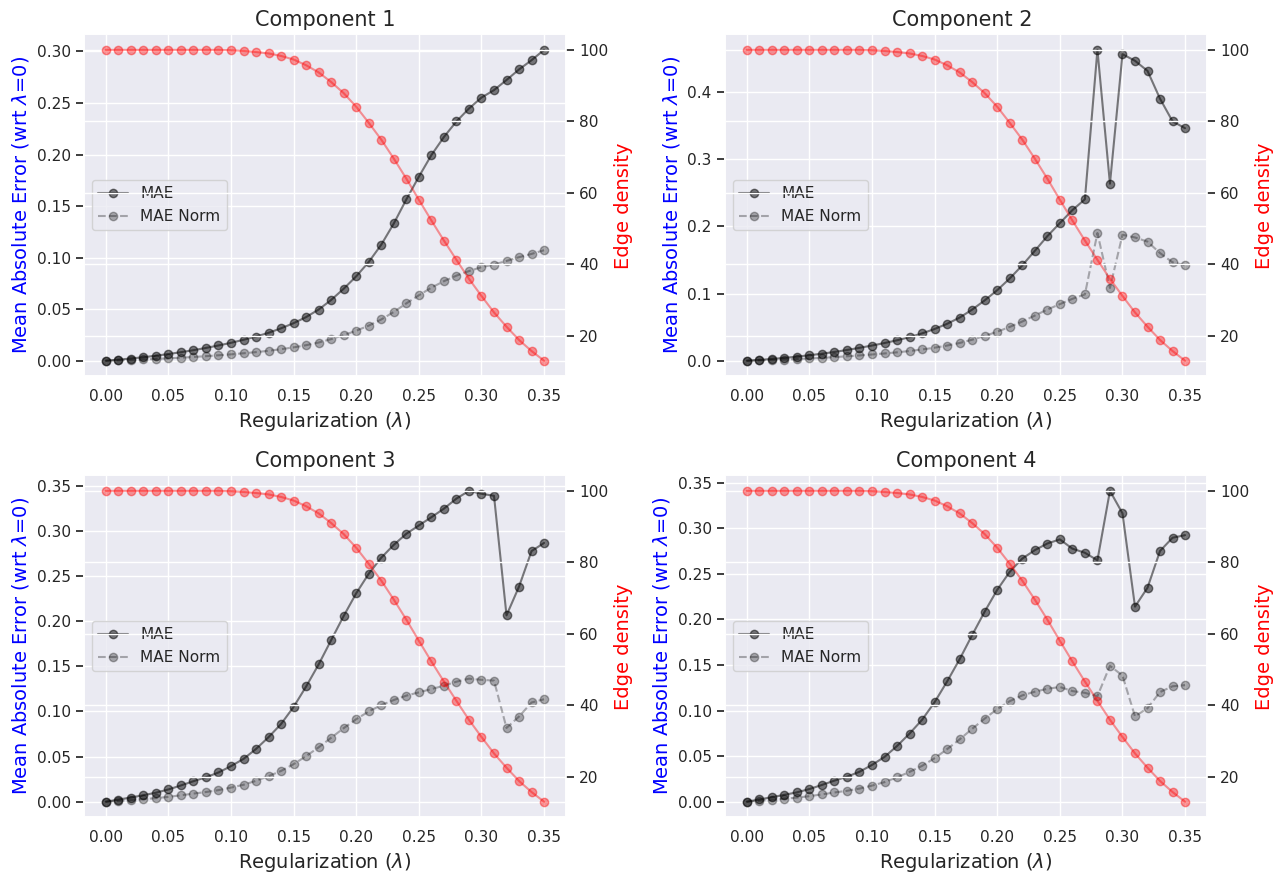

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

ax = axes[0][0]
ax.set_title(f'Component 1', fontsize=15)
ax.plot(lamdas, mae_outer[0], color="black", marker="o", alpha=0.5, label='MAE')
ax.plot(lamdas, mae_normalized[0], '--', color="black", marker="o", alpha=0.3, label='MAE Norm')
ax.set_xlabel("Regularization ($\lambda$)", fontsize = 14)
ax.set_ylabel("Mean Absolute Error (wrt $\lambda$=0)", color="blue", fontsize=14)
ax2=ax.twinx()
ax2.plot(lamdas, sparse_outer[0],color="red",marker="o", alpha=0.4)
ax2.set_ylabel("Edge density", color="red",fontsize=14)
ax.legend(loc='center left')


ax = axes[0][1]
ax.set_title(f'Component 2 ', fontsize=15)
ax.plot(lamdas, mae_outer[1], color="black", marker="o", alpha=0.5, label='MAE')
ax.plot(lamdas, mae_normalized[1], '--', color="black", marker="o", alpha=0.3, label='MAE Norm')
ax.legend(loc='center left')
ax.set_xlabel("Regularization ($\lambda$)", fontsize = 14)
ax.set_ylabel("Mean Absolute Error (wrt $\lambda$=0)", color="blue", fontsize=14)
ax2=ax.twinx()
ax2.plot(lamdas, sparse_outer[1],color="red",marker="o", alpha=0.4)
ax2.set_ylabel("Edge density", color="red",fontsize=14)

ax = axes[1][0]
ax.set_title(f'Component 3', fontsize=15)
ax.plot(lamdas, mae_outer[2], color="black", marker="o", alpha=0.5, label='MAE')
ax.plot(lamdas, mae_normalized[2], '--', color="black", marker="o", alpha=0.3, label='MAE Norm')
ax.legend(loc='center left')
ax.set_xlabel("Regularization ($\lambda$)", fontsize = 14)
ax.set_ylabel("Mean Absolute Error (wrt $\lambda$=0)", color="blue", fontsize=14)
ax2=ax.twinx()
ax2.plot(lamdas, sparse_outer[2],color="red",marker="o", alpha=0.4)
ax2.set_ylabel("Edge density", color="red",fontsize=14)

ax = axes[1][1]
ax.set_title(f'Component 4', fontsize=15)
ax.plot(lamdas, mae_outer[3], color="black", marker="o", alpha=0.5, label='MAE')
ax.plot(lamdas, mae_normalized[3], '--', color="black", marker="o", alpha=0.3, label='MAE Norm')
ax.legend(loc='center left')
ax.set_xlabel("Regularization ($\lambda$)", fontsize = 14)
ax.set_ylabel("Mean Absolute Error (wrt $\lambda$=0)", color="blue", fontsize=14)
ax2=ax.twinx()
ax2.plot(lamdas, sparse_outer[3],color="red",marker="o", alpha=0.4)
ax2.set_ylabel("Edge density", color="red",fontsize=14)


plt.tight_layout()
plt.show()